**Initial Dataprocessing**

Importing as an array file, and supressing zeros from dataset

Replace the 'FileName' field for the filename to be analyzed


In [8]:
import csv

FileName = 'CEM III.csv'
SupressZeros = True

# importing csv file as an array file
with open(FileName) as csv_file:
    csv_file = list(csv.reader(csv_file, delimiter=';'))

# with zero supressing
if SupressZeros:
    csv_zero_supressed = csv_file
    for _index in range(len(csv_zero_supressed) - 1, 0, -1):
        if csv_zero_supressed[_index][1] == '0':
            del csv_zero_supressed[_index]
    x_header = csv_zero_supressed[0][0]
    x_axis = [float(_lines[0].replace(',','.')) for _lines in csv_zero_supressed[1:]]
    y_header = csv_zero_supressed[0][1]
    y_axis = [float(_lines[1].replace(',','.')) for _lines in csv_zero_supressed[1:]]

# without zero supressing
else:
    x_header = csv_file[0][0]
    x_axis = [float(_lines[0].replace(',','.')) for _lines in csv_file[1:]]
    y_header = csv_file[0][1]
    y_axis = [float(_lines[1].replace(',','.')) for _lines in csv_file[1:]]

**Smoothing the Data using ANN**

Implementation using an Multilayer Perceptron Regressor

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#input definition
X, y = pd.DataFrame(x_axis), pd.DataFrame(y_axis)
X = X.values.reshape(-1,1)

# dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


# ANN definition
regr = MLPRegressor(hidden_layer_sizes=(2000, 100),
                    activation='tanh',
                    solver='lbfgs',
                    max_iter=20000,
                    random_state=0,
                    tol=0.001)

# model fitting
regr.fit(X_train, y_train)

# rqnge prediction
y_predicted = regr.predict(X)

**Initial Data Visualization**


****
R2 Score: 0.9671


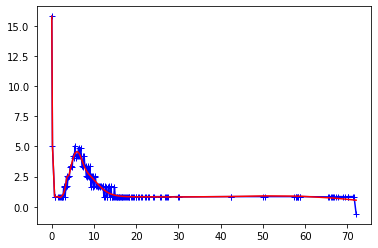

In [9]:
# R2 Score Evaluation
print('\n****\nR2 Score: {:.4f}'.format(float(r2_score(y_axis, y_predicted))))

# Graph plotting
plt.plot(x_axis, y_axis, marker='+', color='blue')
plt.plot(x_axis, y_predicted, color='red')
plt.show()

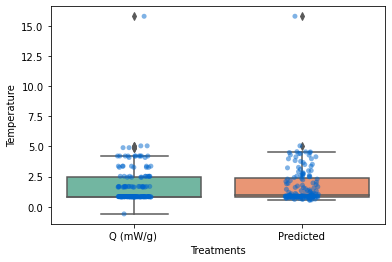

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data file
df = pd.DataFrame({y_header + ' ': y_axis, 'Predicted':y_predicted})

# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'])

# replace column names
df_melt.columns = ['index', 'Treatments', 'Temperature']

sns.set_palette('Set2')
ax = sns.boxplot(x='Treatments', y='Temperature', data=df_melt)
ax = sns.stripplot(x='Treatments', y='Temperature', data=df_melt, color='#0066cc', alpha=0.5)
plt.show()

**ANOVA Analysis**

In [17]:
from bioinfokit.analys import stat

# model definition and summary
anova = stat()
anova.anova_stat(df=df_melt, res_var='Temperature', anova_model='Temperature ~ C(Treatments)')
anova.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Treatments),1.0,0.015166,0.015166,0.005551,0.940659
Residual,306.0,836.066550,2.732244,NaN,NaN


**Quantiles, Standardized Residuals and Frequency Plots**

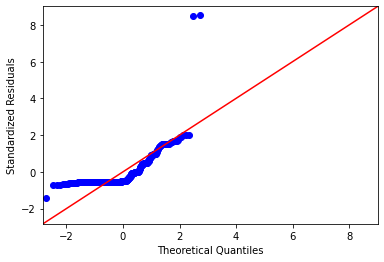

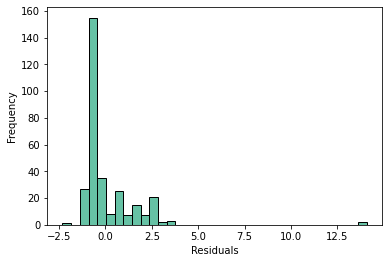

In [20]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(anova.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(anova.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

**TUKEY HSD Test Analysis**

Alternatively, Scheffe’s method is completely coherent with ANOVA and considered as more appropriate post hoc test for significant ANOVA for all unplanned comparisons. However, it is highly conservative than other post hoc tests.

In [21]:
import warnings
from bioinfokit.analys import stat

# warning supressing
warnings.simplefilter(action='ignore', category=FutureWarning)

# model definition and summary
tukey = stat()
tukey.tukey_hsd(df=df_melt, res_var='Temperature', xfac_var='Treatments', anova_model='Temperature ~ C(Treatments)')
tukey.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Q (mW/g),Predicted,0.014034,-0.356632,0.384701,0.105364,0.9


**Shapiro-Wilk test**

Can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution

In [23]:
from bioinfokit.analys import stat

# model definition and summary
shapiro = stat()
shapiro.bartlett(df=df_melt, res_var='Temperature', xfac_var='Treatments')
shapiro.bartlett_summary

,Parameter,Value
0,Test statistics (T),0.0217
1,Degrees of freedom (Df),1.0000
2,p value,0.8830


**Levene's test**

Can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [63]:
from bioinfokit.analys import stat 

# model definition and summary
levene = stat()
levene.levene(df=df_melt, res_var='Temperature', xfac_var='Treatments')
levene.levene_summary

,Parameter,Value
0,Test statistics (W),0.0050
1,Degrees of freedom (Df),1.0000
2,p value,0.9437


**Numerical Derivation Process**


Return the gradient of an N-dimensional array.

The gradient is computed using second order accurate central differences in the interior points and either first or second order accurate one-sides (forward or backwards) differences at the boundaries. The returned gradient hence has the same shape as the input array.

Docs: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

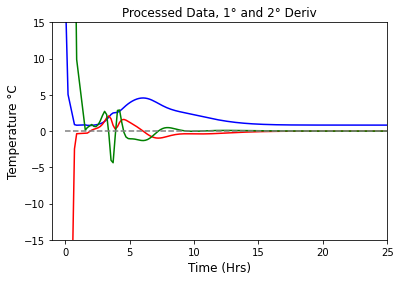

In [50]:
import numpy as np 
from scipy.misc import derivative

x_initial = np.array(x_axis)
y_initial = np.array(y_predicted)

# deriv process
der1 = np.gradient(y_initial,x_initial)
der2 = np.gradient(der1,x_initial)

# graph labels
plt.title("Processed Data, 1° and 2° Deriv",fontsize=12)
plt.ylabel("Temperature °C",fontsize=12)
plt.xlabel("Time (Hrs)",fontsize=12)

# data series
plt.plot(x_initial, y_initial, color='blue')
plt.plot(x_initial, der1, color='red')
plt.plot(x_initial, der2, color='green')
plt.plot(np.zeros_like(x_initial), "--", color="gray")

# graph limits
plt.xlim(-1,25)
plt.ylim(-15,15)

plt.show()

**Signal Finds Peaks and Valleys**

Find peaks inside a signal based on peak properties.

This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.

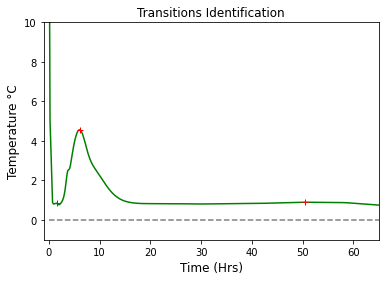

First Transition: 1.56 hrs
Second Transition: 6.06 hrs
Last Transition: 50.56 hrs


In [76]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

# peaks and valey identification
peaks, _ = find_peaks(y_predicted, distance=20)

plt.plot(x_axis, y_predicted, color="green")
plt.plot([x_axis[_x_values] for _x_values in peaks], y_predicted[peaks], "+", color="red")
plt.plot(np.zeros_like(y_predicted), "--", color="gray")

# graph limits
plt.xlim(-1,65)
plt.ylim(-1,10)

# graph labels
plt.title("Transitions Identification",fontsize=12)
plt.ylabel("Temperature °C",fontsize=12)
plt.xlabel("Time (Hrs)",fontsize=12)

plt.show()

print('First Transition: {:.2f} hrs'.format(x_axis[peaks[0]]))
print('Second Transition: {:.2f} hrs'.format(x_axis[peaks[1]]))
print('Last Transition: {:.2f} hrs'.format(x_axis[peaks[-1]]))
